In [444]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [450]:
df = pd.read_csv('./data_for_modelling.csv')

In [451]:
num_df = df.select_dtypes(exclude = 'object')
cat_df = df.select_dtypes(include = 'object')

Log transform turns out to be most suitable for our distribution as the other two scaling methods failed to deal with outliers effectively 

In [452]:
num_df['avg_yearly_sal'] = num_df['avg_yearly_sal'].apply(lambda x: np.log(x) if x>0 else 0)

<ipython-input-452-81ff5d350291>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df['avg_yearly_sal'] = num_df['avg_yearly_sal'].apply(lambda x: np.log(x) if x>0 else 0)


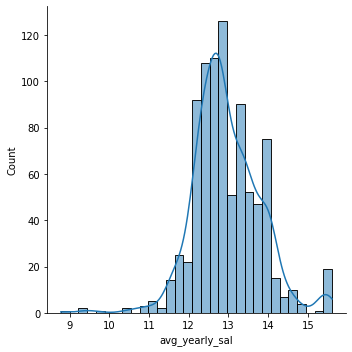

In [453]:
sns.displot(num_df['avg_yearly_sal'], kde=True)

Now our annual salary distribution looks quite uniform

Lets do the train test split<br>
<b> Note </b> : Here we are using train test split as dataset is quite small but if you have a much bigger dataset you might want to consider using stratified shuffle split.<br>
In our case train test split gave better results compared to stratified shuffling

In [454]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(num_df.drop('avg_yearly_sal', axis=1), num_df['avg_yearly_sal'], test_size=100, random_state=42)

In [455]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

In [456]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor

In [204]:
rnd_reg = RandomForestRegressor(oob_score=True, random_state=42)
rnd_reg.fit(X_train , y_train)

RandomForestRegressor(oob_score=True, random_state=42)

In [205]:
col_names = num_df.drop('avg_yearly_sal', axis=1).columns

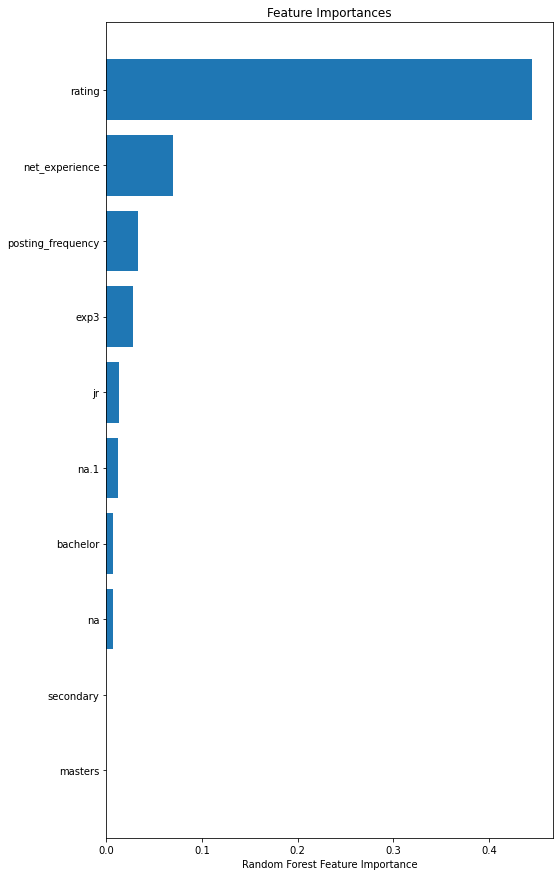

In [206]:
# plot to see top 10 important features by random forest
plt.figure(figsize=(8,15))
importances = rnd_reg.feature_importances_ [:10]
idxs = np.argsort(importances) 
plt.title('Feature Importances') 
plt.barh(range(len(idxs)), importances[idxs], align='center') 
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs]) 
plt.xlabel('Random Forest Feature Importance') 
plt.show() 

In [207]:
rnd_reg.oob_score_

0.509775441150256

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

Lets tune our random forest for better performance

In [ ]:
param_grid = {'n_estimators' : [100,300, 500]}
grid = GridSearchCV(RandomForestRegressor(), param_grid=param_grid)
grid.fit(X_train, y_train)
rnd_best = grid.best_estimator_

In [458]:
#filename = 'rnd_best.sav'
#pickle.dump(rnd_best, open(filename, 'wb'))

Now we will train and fine tune many models namely Lasso regression, Decision tree, Random Forest, Extra trees, Gradient Boosted trees, Xgboost and then using Voting regressor on best performing models

In [317]:
from sklearn.linear_model import Lasso
lasso = Lasso(random_state=42)
param_grid = {'alpha': np.arange(1,101)/100, 'max_iter': [1000, 3000, 6000, 10000]} 
grid = GridSearchCV(lasso, param_grid=param_grid)
grid.fit(X_train, y_train)
lasso_best = grid.best_estimator_
pred = lasso_best.predict(X_test)

In [92]:
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

719235.0548970881

In [179]:
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor(criterion='mae', random_state=42)
dtree.fit(X_train, y_train)
pred = dtree.predict(X_test)

In [180]:
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

390581.1408406693

In [95]:
from xgboost import XGBRegressor
xgr = XGBRegressor(random_state=42)
xgr.fit(X_train, y_train)
pred = xgr.predict(X_test)

In [96]:
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

477555.6361423906

In [308]:
param_grid = {"learning_rate"    : [0.05, 0.20, 0.30 ] ,
                "max_depth"        : [ 3, ],
                "gamma"            : [ 0.1, 0.4 ],
              }

In [440]:
grid = GridSearchCV(xgr, param_grid=param_grid)
grid.fit(X_train, y_train)
xgr_best = grid.best_estimator_
pred = xgr_best.predict(X_test)

In [441]:
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

416166.75956758315

In [420]:
#filename = 'xgr_best.sav'
#pickle.dump(xgr_best, open(filename, 'wb'))

In [436]:
from sklearn.ensemble import ExtraTreesRegressor
extra_reg = ExtraTreesRegressor(n_estimators=500, random_state=42)
extra_reg.fit(X_train, y_train)
pred = extra_reg.predict(X_test)

In [437]:
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

438762.35235329374

In [421]:
#filename = 'Extra_best.sav'
#pickle.dump(extra_reg, open(filename, 'wb'))

In [434]:
from sklearn.ensemble import GradientBoostingRegressor
grb_reg = GradientBoostingRegressor(loss='lad', random_state=42)
grb_reg.fit(X_train, y_train)
pred = grb_reg.predict(X_test)

In [435]:
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

498879.956064848

In [422]:
#filename = 'GB_best.sav'
#pickle.dump(grb_reg, open(filename, 'wb'))

Now using Voting regressor to train on the best performing models so far, which averages the individual prediction to form a final prediction.

In [339]:
vot_reg = VotingRegressor(estimators=[('rf', rnd_best), ('xg', xgr_best), ('gb', grb_reg), ('eg', extra_reg)])

In [438]:
vot_reg.fit(X_train, y_train)
pred = vot_reg.predict(X_test)

In [439]:
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

402993.456604134

In [423]:
#filename = 'Voting_best.sav'
#pickle.dump(vot_reg, open(filename, 'wb'))

We can see that we have used some really powerful models like <b>Random forest</b>, <b>ExtraTrees</b>, <b>Gradient boosted trees</b> and <b>Xgboost</b> models as the complexity of problem is high but the available data is small. (784 training and 100 test examples) <br>
Lets go one step further and create a blender of best models so far, to squeeze a bit more performance from our models

In [424]:
estimators = [rnd_best, xgr_best, vot_reg, dtree, extra_reg, grb_reg]

In [425]:
X_train_predictions = np.empty((len(X_train), len(estimators)), dtype = np.float32)

In [426]:
for index, estimator in enumerate(estimators):
    X_train_predictions[:, index] = estimator.predict(X_train)

In [427]:
rnd_reg1 = RandomForestRegressor(n_estimators=100,oob_score=True, random_state=42)

In [428]:
rnd_reg1.fit(X_train_predictions, y_train)

RandomForestRegressor(oob_score=True, random_state=42)

In [429]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype = np.float32)

In [430]:
for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [431]:
pred = rnd_reg1.predict(X_test_predictions)

In [432]:
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

363761.36489404563

In [337]:
from sklearn.metrics import r2_score

In [433]:
r2_score(y_test, pred)

0.5201458762557272

Our model explains half of the observed variation, which is acceptable if not great.   <br>
We can also conclude that the model can give much better predictions if fed with more data.

RandomForestRegressor(n_estimators=300)